In [1]:
#Import libreries:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats
from scipy import odr

import corner 

from urllib.error import HTTPError

# Estimation of $T_{Heavy}$ without temperature fluctions  $t^2 = 0$ 

In [2]:
## Update the tables with the information to use:

total_abundances = pd.read_csv('total_abundances_t2eq0.txt', delim_whitespace = ' ')
ionic_abundances = pd.read_csv('ionic_abundances_t2eq0.txt', delim_whitespace = ' ')
physical_conditions = pd.read_csv('physical_conditions.txt', delim_whitespace = ' ')

#Filter the regions by type:

#HII Regions:

total_HII_filter = total_abundances[total_abundances['File'].str.startswith('HII_')]
ionic_HII_filter = ionic_abundances[ionic_abundances['File'].str.startswith('HII_')]
physical_HII_filter = physical_conditions[physical_conditions['File'].str.startswith('HII_')]

#SFG Regions:

total_SFG_filter = total_abundances[total_abundances['File'].str.startswith('SFG_')]
ionic_SFG_filter = ionic_abundances[ionic_abundances['File'].str.startswith('SFG_')]
physical_SFG_filter = physical_conditions[physical_conditions['File'].str.startswith('SFG_')]

print('Este es el número total de regiones HII:', len(total_HII_filter))
print('Este es el número total de regiones SFG:', len(total_SFG_filter))
print('Este es el número total de conjunto de HII y SFG:', len(total_HII_filter) + len(total_SFG_filter))

Este es el número total de regiones HII: 1263
Este es el número total de regiones SFG: 1459
Este es el número total de conjunto de HII y SFG: 2722


## Calculate $T_{heavy}$
- We calculate $T_{heavy}$ with their uncertainties using MonteCarlo

- The Formula for $T_{heavy}$ is:

$$\text{T}_{heavy} = \dfrac{\text{[OIII]}_{\text{abundance}}}{\text{O}_{\text{abundance}}}\text{T}_e[\text{OIII}] + \dfrac{\text{OII}_{\text{abundance}}}{O_{\text{abundance}}}\text{T}_e[NII] $$

- Recall that by definition we have the following relations:

$$ Log\left( \dfrac{\text{OIII}}{\text{H}} \right) + 12 = \epsilon(\text{OIII}) $$


$$ Log\left( \dfrac{\text{OII}}{\text{H}} \right) + 12 = \epsilon(\text{OII})$$

$$ Log\left( \dfrac{\text{O}}{\text{H}} \right) + 12 =  \epsilon(\text{O}) $$

- The linean form is then:

$$ \text{T}_{heavy} = 10^{(\text{[OIII]} - \text{O})}\text{T}_e[\text{OIII}] + 10^{(\text{[OII]} - \text{O})}\text{T}_e[\text{NII}] $$

In [3]:
## This function estimate our lineal fit using ODR:

def linfit(x, y, xerr_low, xerr_high, yerr_low, yerr_high):
    """
    Perform a lineal fit to data with asymmetric uncertainties in x and y using Orthogonal Distance Regression (ODR)
    
    Parametres: 
        x = Data in the x axis (1D Array)
        y = Data in the y axis (1D Array)
        xerr_low = Lower error in x (1D Array)
        xerr_high = Upper error in x (1D Array)
        yerr_low = Lower error in y (1D Array)
        yerr_high = Upper error in y (1D Array)
    
    
    Return: m, e_m, c, e_c, correlation_coefficient
        m = Slope (Scalar)
        e_m = Error in the Slope (Scalar)
        c = Intercept (Scalar)
        e_c = Error in the Intercept (Scalar)
        correlation_coefficient = Correlation coefficient between the parametres (Scalar)
    """
    #Make conditionals:
    
    if xerr_high is None and xerr_low is None:
        raise  ValueError("At least one of x errors must be provided.")
    elif xerr_high is None:
        x_e = xerr_low
    elif xerr_low is None:
        x_e = xerr_high
    else:
        x_e = (xerr_high + xerr_low)/2
        
    if yerr_high is None and yerr_low is None:
        raise ValueError('At least one of y erros must be provided.')
    elif yerr_high is None:
        y_e = yerr_low
    elif yerr_low is None:
        y_e = yerr_high
    else:
        y_e = (yerr_high + yerr_low)/2
    
    #Define the lineal function
    
    def func(p, x):

        m,b = p
        return m*x + b
 
    quad_model = odr.Model(func)
    
    # Create a RealData object
    data = odr.RealData(x,y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[0., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
    
    #covarance_matrix and variance_residuals
    cov_mx = out.cov_beta 
    res_var = out.res_var
    
    # Full (unscaled) covariance matrix
    cov = cov_mx*res_var         
    
  
    c=popt[1]
    e_c=perr[1]
    
    m=popt[0]
    e_m=perr[0]

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  c, e_c, m, e_m, correlation_coefficient,res_var, cov, popt


# This function estimate a quadratic adjustment:

def quadratic_fit(x, y, xerr_low, xerr_high, yerr_low, yerr_high):
    """
    Perform a quadratic fit to data with asymmetric uncertainties in x and y using Orthogonal Distance Regression (ODR).

    Parameters:
        x (array-like): 1D array of x-axis data.
        y (array-like): 1D array of y-axis data.
        xerr_low (array-like): Lower uncertainties in x.
        xerr_high (array-like): Upper uncertainties in x.
        yerr_low (array-like): Lower uncertainties in y.
        yerr_high (array-like): Upper uncertainties in y.

    Returns:
        a (float): Quadratic coefficient (x^2 term).
        e_a (float): Error in the quadratic coefficient.
        b (float): Linear coefficient (x term).
        e_b (float): Error in the linear coefficient.
        c (float): Intercept (constant term).
        e_c (float): Error in the intercept.
        correlation_coefficient (float): Pearson correlation coefficient between x and y.
    """
    
    #Make conditionals:
    
    if xerr_high is None and xerr_low is None:
        raise  ValueError("At least one of x errors must be provided.")
    elif xerr_high is None:
        x_e = xerr_low
    elif xerr_low is None:
        x_e = xerr_high
    else:
        x_e = (xerr_high + xerr_low)/2
        
    if yerr_high is None and yerr_low is None:
        raise ValueError('At least one of y erros must be provided.')
    elif yerr_high is None:
        y_e = yerr_low
    elif yerr_low is None:
        y_e = yerr_high
    else:
        y_e = (yerr_high + yerr_low)/2
        
    #Define the shape of the function, in this case is quadratic:
    def quadratic(theta,x):
        a, b, c = theta
        model = a*x**2 + b*x + c
        return model
 
    quad_model = odr.Model(quadratic)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[0., 1., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
    
    #covarance_matrix and variance_residuals
    cov_mx = out.cov_beta 
    res_var = out.res_var
    
    # Full (unscaled) covariance matrix
    cov = cov_mx*res_var    
    
    a=popt[0]
    e_a=perr[0]
    
    b=popt[1]
    e_b=perr[1]
    
    c = popt[2]
    e_c = perr[2]
    


    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  a, e_a, b, e_b,c, e_c, correlation_coefficient, res_var, cov, popt

#This function estimate T_heavy and their uncertainties:

def T_heavy(Name, O3, O2, O, Te_O3, Te_Ne, e_Om, e_Op, e_Te_O3m, e_Te_O3p, e_Te_Nem, e_Te_Nep):
    
    """
    Estimate the heavy element temperature (T_heavy) in ionized regions using ionic oxygen abundances and 
    electron temperatures derived from [OIII] and [NII] emission lines. Also calculates asymmetric uncertainties 
    using Monte Carlo simulations.

    Parameters:
        Name (pd.Series): Identifiers for the observed regions (e.g., HII or SFG regions).
        O3 (pd.Series): Ionic abundance of [OIII] (O++/H+).
        O2 (pd.Series): Ionic abundance of [OII] (O+/H+).
        O (pd.Series): Total abundance of Oxygen (O/H).
        Te_O3 (pd.Series): Electron temperature derived from [OIII] emission.
        Te_Ne (pd.Series): Electron temperature derived from [NII] emission.
        e_Om (pd.Series): Lower uncertainty on total Oxygen abundance.
        e_Op (pd.Series): Upper uncertainty on total Oxygen abundance.
        e_Te_O3m (pd.Series): Lower uncertainty on Te_O3.
        e_Te_O3p (pd.Series): Upper uncertainty on Te_O3.
        e_Te_Nem (pd.Series): Lower uncertainty on Te_Ne.
        e_Te_Nep (pd.Series): Upper uncertainty on Te_Ne.

    Returns:
        pd.DataFrame: A dataframe with the following columns:
            - Name: Region identifier.
            - O3_abundance: Ionic abundance of [OIII].
            - O2_abundance: Ionic abundance of [OII].
            - O_abundance: Total Oxygen abundance.
            - e_O_abundancem: Lower uncertainty of O_abundance.
            - e_O_abundancep: Upper uncertainty of O_abundance.
            - Te_[OIII]: Electron temperature from [OIII].
            - e_Te_[OIII]m: Lower uncertainty of Te_[OIII].
            - e_Te_[OIII]p: Upper uncertainty of Te_[OIII].
            - Te_[NeII]: Electron temperature from [NII].
            - e_Te_[NeII]m: Lower uncertainty of Te_[NeII].
            - e_Te_[NeII]p: Upper uncertainty of Te_[NeII].
            - T_heavy: Estimated heavy element temperature.
            - e_T_heavy: Lower uncertainty of T_heavy.
            - E_T_heavy: Upper uncertainty of T_heavy.

    Notes:
        The function uses a Monte Carlo method with 10,000 samples to propagate the uncertainties in the input 
        temperatures into the final T_heavy value. It assumes that the electron temperature errors are symmetric
        and follows a normal distribution.
    """
    
    #Mask: This mask quit all the nan's values
    
    mask = ~np.isnan(O3) & ~np.isnan(O2) & ~np.isnan(O) & ~np.isnan(Te_O3) & ~np.isnan(Te_Ne) & ~np.isnan(e_Te_O3m) &\
            ~np.isnan(e_Te_O3p) & ~np.isnan(e_Te_Nem) & ~np.isnan(e_Te_Nep) & ~np.isnan(e_Om) & ~np.isnan(e_Op)
    
    #Apply mask:
    Name= Name[mask].reset_index(drop=True)
    O3= O3[mask].reset_index(drop =True)
    O2 = O2[mask].reset_index(drop=True)
    O = O[mask].reset_index(drop=True)
    Te_O3 = Te_O3[mask].reset_index(drop=True)
    Te_Ne = Te_Ne[mask].reset_index(drop=True)
    e_Om = e_Om[mask].reset_index(drop = True)
    e_Op = e_Op[mask].reset_index(drop = True)
    e_Te_O3m = e_Te_O3m[mask].reset_index(drop=True)
    e_Te_O3p = e_Te_O3p[mask].reset_index(drop=True)
    e_Te_Nem = e_Te_Nem[mask].reset_index(drop=True)
    e_Te_Nep = e_Te_Nep[mask].reset_index(drop=True)
    
    #T_heavy:
    T = 10**(O3 - O)*Te_O3 + 10**(O2 - O)*Te_Ne
    
    #Create the MonteCarlo Simulations:
    
    #Sample Number of MonteCarlo
    n_samples = 10**5
    
    #Empthy listes:

    e_T_list = [] #Arreglo vacio que almacenará los datos del error minus
    E_T_list = [] #Arreglo vacio que almacenará los datos del error plus

    #Vamos a crear una serie de simulaciones MonteCarlo para cada row de nuestro dataframe:
    
    #Hacemos una simulación MonteCarlo de 100000 muestras para cada Row de nuestro dataframe
        
    T_samples = np.random.standard_normal(n_samples)
    
    for i in range(len(O3)):
        
        #First term of T_{heavy}:
        T_heavy1 = T_samples*(e_Te_O3m[i]/2 + e_Te_O3p[i]/2)*10**(O3[i] - O[i]) + 10**(O3[i] - O[i])*Te_O3[i]
      
        #Second term of T_{heavy}:
        T_heavy2 = T_samples*(e_Te_Nem[i]/2 + e_Te_Nep[i]/2)*10**(O2[i] - O[i]) + 10**(O2[i] - O[i])*Te_Ne[i]
    
        #Sum of our function:
        T_sum = T_heavy1 + T_heavy2
        
        #T_central:
        T_central = np.median(T_sum)
    
        #Erros:
        e_Thp = round(np.percentile(T_sum, 84) - T_central,2)
        
        e_Thm = round(T_central - np.percentile(T_sum, 16),2)
        
        #Concatenar:
    
        e_T_list.append(e_Thp)
        
        
        E_T_list = np.append(E_T_list, np.absolute(e_Thp)) 
    
    if Name[0].startswith('HII'):
        print('Total HII regions:', len(O3), '\n')
    else:
        print('Total SFG regions:', len(O3), '\n')
    
    
    data = {'Name': Name, 'O3_abundance': O3,'O2_abundance': O2,'O_abundance': O,'e_O_abundancem': e_Om,
        'e_O_abundancep': e_Op, 'Te_[OIII]': Te_O3, 'e_Te_[OIII]m': e_Te_O3m,'e_Te_[OIII]p': e_Te_O3p, 
        'Te_[NeII]': Te_Ne, 'e_Te_[NeII]m': e_Te_Nem,'e_Te_[NeII]p': e_Te_Nep, 'T_heavy': T, 'e_T_heavy': e_T_list,
        'E_T_heavy': E_T_list}
    
    return pd.DataFrame(data)

#This function is going to choose the model to apply asking the using what model use:

def model(T, O, e_T_list, E_T_list, e_Om, e_Op, model_type = None):
    
    """
    Fit a model (linear or quadratic) to the relationship between temperature and oxygen abundance,
    accounting for asymmetric uncertainties using Orthogonal Distance Regression (ODR). Also provides
    standard regression fits for comparison (using `linregress` for linear and `np.polyfit` for quadratic).

    Parameters:
        T (pd.Series or np.ndarray): Temperature values (e.g., T_heavy).
        O (pd.Series or np.ndarray): Oxygen abundances corresponding to each temperature value.
        e_T_list (pd.Series or np.ndarray): Lower uncertainties on temperature values.
        E_T_list (pd.Series or np.ndarray): Upper uncertainties on temperature values.
        e_Om (pd.Series or np.ndarray): Lower uncertainties on oxygen abundance values.
        e_Op (pd.Series or np.ndarray): Upper uncertainties on oxygen abundance values.
        model_type (str, optional): Type of model to fit. Must be 'Lineal' or 'Quadratic'. 
                                    If None, the function prompts the user to choose.

    Returns:
        tuple:
            If model_type == 'Lineal':
                - ODR (tuple): Parameters from the linear ODR fit.
                - Linre (LinregressResult): Output from `scipy.stats.linregress`.
                - ODR_Residual (np.ndarray): Residuals from ODR linear fit.
                - Linre_Residual (np.ndarray): Residuals from `linregress` linear fit.
            
            If model_type == 'Quadratic':
                - ODR_Quadratic (tuple): Parameters from the quadratic ODR fit.
                - Polyfit (np.ndarray): Coefficients from `np.polyfit` quadratic fit (order 2).
                - ODR_Quadratic_Residual (np.ndarray): Residuals from ODR quadratic fit.
                - Polyfit_Quadratic_Residual (np.ndarray): Residuals from `np.polyfit` quadratic fit.

    Raises:
        ValueError: If `model_type` is not 'Lineal' or 'Quadratic'.

    Notes:
        - ODR accounts for uncertainties in both independent and dependent variables.
        - `linregress` is used for a simple least-squares linear model without error consideration.
        - `np.polyfit` is used for standard quadratic fitting without error propagation.
        - Residuals represent the difference between observed oxygen abundances and model predictions.
    """
    
    #Apply Model:
    
    if model_type is None:
        model_type = input("Choose model type ('Lineal' or 'Quadratic'): ").strip().capitalize()
        
    if model_type == 'Lineal': 
        #Lineals
        ODR = linfit(T, O, e_T_list, E_T_list, e_Om, e_Op)
        print('These are the parameters for the Lineal adjustment ODR:\n',  ODR, '\n')
        
        Linre = stats.linregress(T, O)
        print('These are the parametres for the Lineal adjustment Linregress:\n', Linre, '\n')
        
        #Model:
        y = ODR[0] + ODR[2]*T
        y2 = Linre[1] + Linre[0]*T
        
        #Residual:
        ODR_Residual = O - y
        Linre_Residual = O - y2
        
        return ODR, Linre, ODR_Residual, Linre_Residual
    
    elif model_type == 'Quadratic':
        #Quadratic
        ODR_Quadratic = quadratic_fit(T, O, e_T_list, E_T_list,e_Om, e_Op)
        print('These are the parametres for the Quadratic adjustment ODR: \n', ODR_Quadratic, '\n')
        
        Polyfit = np.polyfit(T, O, 2)
        print('These are the parametres for the Quadratic adjustment Polifit:\n', Polyfit, '\n')
        
        #Model:
        y3 = ODR_Quadratic[4] + ODR_Quadratic[2]*T + ODR_Quadratic[0]*T**2
        y4 = Polyfit[2] + Polyfit[1]*T + Polyfit[0]*T**2
        
        #Residual:
        ODR_Quadratic_Residual = O - y3
        Polyfit_Quadratic_Residual = O - y4
        
        return ODR_Quadratic, Polyfit, ODR_Quadratic_Residual, Polyfit_Quadratic_Residual
    
    else:
        raise ValueError("model_type must be 'Lineal' or 'Quadratic'")

#Create simple plots:

def plot(x, y, xerr_low, xerr_high, yerr_low, yerr_high):
    """
    Parameters:
        x (array-like): Values of T_heavy (temperature).
        y (array-like): Oxygen abundance values (12 + log(O/H)).
        xerr_low (array-like): Lower uncertainties for x (T_heavy).
        xerr_high (array-like): Upper uncertainties for x (T_heavy).
        yerr_low (array-like): Lower uncertainties for y (oxygen abundance).
        yerr_high (array-like): Upper uncertainties for y (oxygen abundance).

    Returns:
        None: Displays a matplotlib plot with asymmetric error bars.
    """
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(x, y, fmt='s', xerr = [xerr_low, xerr_high], yerr = [yerr_low, yerr_high], elinewidth = 2, mec = 'k',
                mfc = 'k', capsize=3, capthick = 2, ecolor= 'gray', label='Data with t$^2$ = 0', alpha = 0.7)
    ax.set_ylabel('$12 + log(O/H)$', size = 12)
    ax.set_xlabel('$T_{heavy}$', size = 12)
    ax.set_title('$12 + \log(O/H)$ vs $T_{heavy}$  with $t^2$ = 0', size = 14)
    ax.grid(False)
    ax.minorticks_on() #minorticks on
    ax.tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
    ax.legend()
    plt.show()

In [4]:
#Use the functions:

SFG = T_heavy(ionic_SFG_filter['File'], ionic_SFG_filter['O3_abundance'], ionic_SFG_filter['O2_abundance'], \
               total_SFG_filter['O_abundance'], physical_SFG_filter['Te_[OIII]_4363_5007'], \
                physical_SFG_filter['Te_[NII]_5755_6584'], total_SFG_filter['e_O_abundancem'], \
                total_SFG_filter['e_O_abundancep'], physical_SFG_filter['e_Te_[OIII]_4363_5007m'], \
                physical_SFG_filter['e_Te_[OIII]_4363_5007p'], physical_SFG_filter['e_Te_[NII]_5755_6584m'], \
               physical_SFG_filter['e_Te_[NII]_5755_6584p'])

HII = T_heavy(ionic_HII_filter['File'], ionic_HII_filter['O3_abundance'], ionic_HII_filter['O2_abundance'], \
               total_HII_filter['O_abundance'], physical_HII_filter['Te_[OIII]_4363_5007'],\
                physical_HII_filter['Te_[NII]_5755_6584'], total_HII_filter['e_O_abundancem'], \
                total_HII_filter['e_O_abundancep'],physical_HII_filter['e_Te_[OIII]_4363_5007m'], \
               physical_HII_filter['e_Te_[OIII]_4363_5007p'], physical_HII_filter['e_Te_[NII]_5755_6584m'], \
               physical_HII_filter['e_Te_[NII]_5755_6584p'])


#Create a New DataFrame with the total of the regions:
Regions = pd.concat([SFG, HII])
Regions = Regions.reset_index()

#See the plot:

#plot(Regions['T_heavy'], Regions['O_abundance'], Regions['e_T_heavy'], Regions['E_T_heavy'],
 #                  Regions['e_O_abundancem'], Regions['e_O_abundancep'])

Total SFG regions: 44 

Total HII regions: 229 



In [5]:
# Create the Adjustment:

#Use 'Regions' to make Lineal adjustment ODR:

Lineal_Model = model(Regions['T_heavy'], Regions['O_abundance'], Regions['e_T_heavy'], Regions['E_T_heavy'], 
            Regions['e_O_abundancem'], Regions['e_O_abundancep'])

Choose model type ('Lineal' or 'Quadratic'): Lineal
These are the parameters for the Lineal adjustment ODR:
 (9.291733357944258, 0.0177035153653014, -9.61294440023497e-05, 1.6733528722633498e-06, -0.9235373006671012, 2.0766624027565093, array([[ 2.80010984e-12, -2.90113410e-08],
       [-2.90113410e-08,  3.13414456e-04]]), array([-9.61294440e-05,  9.29173336e+00])) 

These are the parametres for the Lineal adjustment Linregress:
 LinregressResult(slope=-9.353652716090857e-05, intercept=9.25255668440055, rvalue=-0.9235373006671, pvalue=8.363416109063958e-115, stderr=2.3594852900488524e-06, intercept_stderr=0.02412398121339947) 



## We have chosen ODR

<IPython.core.display.Javascript object>


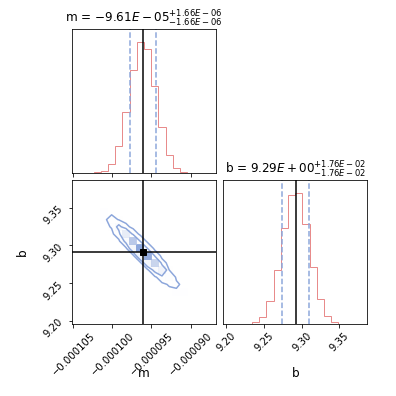

In [6]:
#X axis for the adjustment:
x = np.linspace(5000, 25000, len(Regions['T_heavy']))

# Modern, professional color palette (consistent with previous suggestion)
colors = {
    'HII': '#e88b8b',       # soft pastel red
    'SFG': '#c5c1c8',
    'ODR': '#8ca6db',       # soft pastel blue
    'Linregress': '#4d4d4d' # dark gray (softer than black, less harsh)
    }


nsamp = 20**6
samples = np.random.multivariate_normal(Lineal_Model[0][7],Lineal_Model[0][6], size=nsamp)

figure = corner.corner(samples, labels=["m", "b"], truths=Lineal_Model[0][7], show_titles=True,title_fmt=".2E",
                        label_kwargs={"fontsize": 12},quantiles=[0.16, 0.84], title_kwargs={'fontsize':12},
                       levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.),  ), plot_datapoints=False,
                       truth_color= 'k', color=colors['ODR'], hist_kwargs={"color": colors['HII']}, max_n_ticks=4,
                      plot_contours = True)
plt.savefig('Cornerplot_lineal_t2eq0.pdf', format = 'pdf', dpi = 300, bbox_inches='tight')

<IPython.core.display.Javascript object>


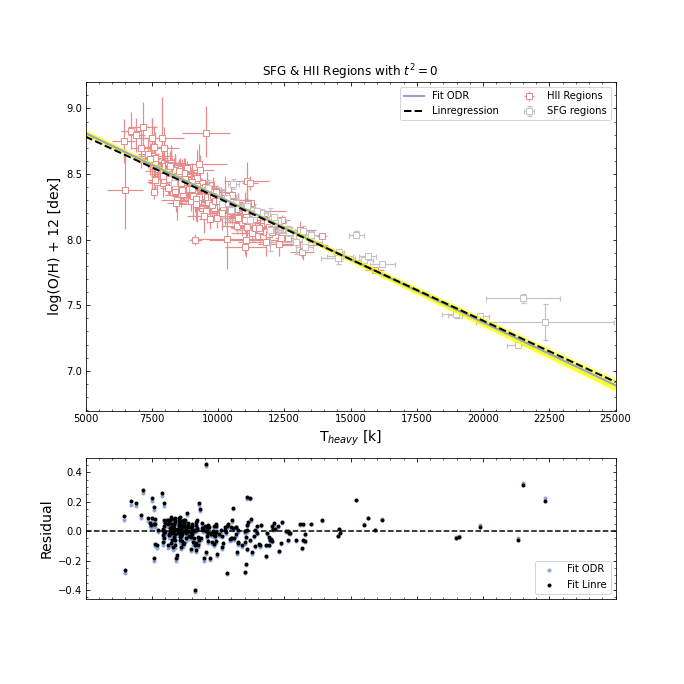

Slope ORD: -0.0000961 ± 0.0000017
Intercept ORD: 9.2917334 ± 0.0177035 

Slope Linregress: -0.0000935 ± 0.0000024
Intercept Linregress:  9.2525567 ± 0.0241


In [29]:
fig, ax = plt.subplots(2, 1, figsize=(9.5, 9.5), sharex=False, gridspec_kw={'height_ratios': [3.5, 1.5]})

inds = np.random.randint(len(samples), size=100)
for ind in inds:
    sample = samples[ind]
    ax[0].plot(x, np.dot(np.vander(x, 2), sample[:2]), color = 'yellow', alpha=0.1, zorder = 2)

# HII
ax[0].errorbar(HII['T_heavy'], HII['O_abundance'], xerr=[HII['e_T_heavy'], HII['E_T_heavy']],
               yerr=[HII['e_O_abundancem'], HII['e_O_abundancep']],fmt = 's', mec=colors['HII'],
                mfc='white', ecolor=colors['HII'], elinewidth=1.2, 
               alpha=1, label = 'HII Regions', zorder = 1)

#SFG
ax[0].errorbar(SFG['T_heavy'], SFG['O_abundance'], xerr = [SFG['e_T_heavy'], SFG['E_T_heavy']],
            yerr = [SFG['e_O_abundancem'], SFG['e_O_abundancep']], fmt = 's',  mec=colors['SFG'],
                mfc='white', ecolor=colors['SFG'], elinewidth=1.2, capsize=2.5, capthick=1.2, 
               alpha=1,  label = 'SFG regions', zorder = 1)
#ODR
ax[0].plot(x,  np.dot(np.vander(x, 2), [Lineal_Model[0][2], Lineal_Model[0][0] ] ), c = colors['ODR'], 
           label = 'Fit ODR', lw = 2, zorder = 2)

#Linregress
ax[0].plot(x, np.dot(np.vander(x, 2), [Lineal_Model[1][0], Lineal_Model[1][1] ] ), '--',c = 'k', 
           label = 'Linregression', lw = 2, zorder = 2)

ax[0].minorticks_on()
ax[0].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
ax[0].set_title('SFG & HII Regions with $t^2 = 0$')
ax[0].set_ylabel(r'log(O/H) + 12 [dex]', size = 14)
ax[0].set_xlabel(r'T$_{heavy}$ [k]', size = 14)
ax[0].set_xlim(5000,25000)
ax[0].grid(False)
ax[0].legend(ncol = 2)

ax[1].minorticks_on() #minorticks on
ax[1].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)

ax[1].scatter(Regions['T_heavy'], Lineal_Model[2], color= colors['ODR'], marker = '.', alpha=1, 
              label = 'Fit ODR', zorder = 0)

ax[1].scatter(Regions['T_heavy'], Lineal_Model[3], color='k', marker = '.', alpha=1, 
              label = 'Fit Linre', zorder = 0)

ax[1].set_xlim(5000,25000)
ax[1].set_xticklabels([])
ax[1].axhline(0, color='k', linestyle='dashed')
ax[1].set_ylabel("Residual", size = 14)
ax[1].legend(loc = 'lower right')

print(f"Slope ORD: {Lineal_Model[0][2]:.7f} ± {Lineal_Model[0][3]:.7f}")
print(f"Intercept ORD: {Lineal_Model[0][0]:.7f} ± {Lineal_Model[0][1]:.7f}", '\n')

print(f'Slope Linregress: {Lineal_Model[1][0]: .7f} ± {Lineal_Model[1][4]:.7f}')
print(f'Intercept Linregress: {Lineal_Model[1][1]: .7f} ± {0.024123:.4f}')

plt.savefig('Lineal_Model_t2eq0.pdf', format = 'pdf', dpi = 300, bbox_inches='tight')

## Lineal Model Results:

$$12 + \log(O/H) = (9.291826 \pm 0.017696) - (0.000096 ± 0.0000016)Te $$

We can express this equation like:

$$ 12 + \log(O/H) = (9.29 \pm 0.01) - (0.96 \pm 0.01) \dfrac{Te}{10^4K} $$

Choose model type ('Lineal' or 'Quadratic'): Quadratic
These are the parametres for the Quadratic adjustment ODR: 
 (2.838049780649697e-10, 3.7629736573601624e-10, -0.00010309067093049607, 9.409417740283868e-06, 9.332084451338652, 0.056597270936547366, -0.9235373006671012, 2.079892324710202, array([[ 1.41599707e-19, -3.48609300e-15,  2.02571194e-11],
       [-3.48609300e-15,  8.85371422e-11, -5.26875210e-07],
       [ 2.02571194e-11, -5.26875210e-07,  3.20325108e-03]]), array([ 2.83804978e-10, -1.03090671e-04,  9.33208445e+00])) 

These are the parametres for the Quadratic adjustment Polifit:
 [ 2.19900233e-09 -1.49355325e-04  9.57755338e+00] 



<IPython.core.display.Javascript object>


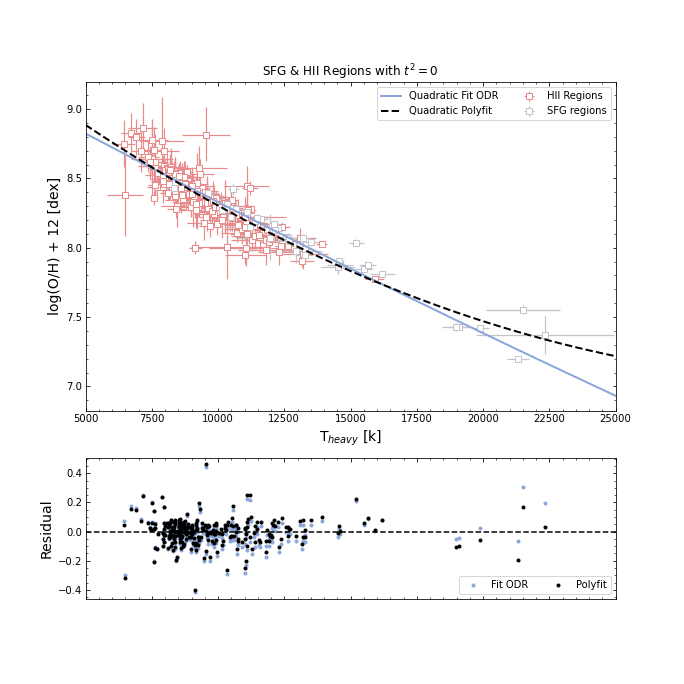

ORD a: 0.00000000028 ± 0.00000000038
ORD b: -0.00010309067 ± 0.00000940942
ORD c: 9.33208445134 ± 0.05659727094 

Poly a: 0.000000002199
Poly b: -0.000149355325
Poly c: 9.577553376914


In [44]:
# Create the Adjustment:

#Use 'Regions' to make Lineal adjustment ODR:

Quadratic_Model = model(Regions['T_heavy'], Regions['O_abundance'], Regions['e_T_heavy'], Regions['E_T_heavy'], 
            Regions['e_O_abundancem'], Regions['e_O_abundancep'])


#Lineal Model Plot:

fig, ax = plt.subplots(2, 1, figsize=(9.5, 9.5), sharex=False, gridspec_kw={'height_ratios': [3.5, 1.5]})

#X axis for the adjustment:
x = np.linspace(5000, 25000, len(Regions['T_heavy']))

# HII
ax[0].errorbar(HII['T_heavy'], HII['O_abundance'], xerr=[HII['e_T_heavy'], HII['E_T_heavy']],
               yerr=[HII['e_O_abundancem'], HII['e_O_abundancep']], fmt = 's', mec=colors['HII'],
                mfc='white', ecolor=colors['HII'], elinewidth=1.2, 
               alpha=1, label = 'HII Regions', zorder = 0)

#SFG
ax[0].errorbar(SFG['T_heavy'], SFG['O_abundance'], xerr = [SFG['e_T_heavy'], SFG['E_T_heavy']],
            yerr = [SFG['e_O_abundancem'], SFG['e_O_abundancep']],  fmt = 's',  mec=colors['SFG'],
                mfc='white', ecolor=colors['SFG'], elinewidth=1.2,
               alpha=1,  label = 'SFG regions', zorder = 0,)

ax[0].plot(x,  np.dot(np.vander(x, 3), [Quadratic_Model[0][0], Quadratic_Model[0][2], Quadratic_Model[0][4] ] ),
           c = colors['ODR'], label = 'Quadratic Fit ODR', lw = 2, zorder = 1)

#Linregress
ax[0].plot(x, np.dot(np.vander(x, 3), [Quadratic_Model[1][0], Quadratic_Model[1][1], Quadratic_Model[1][2] ] ), '--',
           c = 'k', label = 'Quadratic Polyfit', lw = 2, 
           zorder = 1)

ax[0].minorticks_on() #minorticks on
ax[0].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
ax[0].set_title('SFG & HII Regions with $t^2 = 0$')
ax[0].set_ylabel('log(O/H) + 12 [dex]', size = 14)
ax[0].set_xlabel('T$_{heavy}$ [k]', size = 14)
ax[0].set_xlim(5000,25000)
ax[0].grid(False)
ax[0].legend(ncol = 2)

ax[1].minorticks_on() #minorticks on
ax[1].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)

ax[1].scatter(Regions['T_heavy'], Quadratic_Model[2], color=colors['ODR'], marker = '.', alpha=1, 
              label = 'Fit ODR', zorder = 0)
ax[1].scatter(Regions['T_heavy'], Quadratic_Model[3], color='k', marker = '.', alpha=1, 
              label = 'Polyfit', zorder = 0)

ax[1].set_xlim(5000,25000)
ax[1].set_xticklabels([])
ax[1].axhline(0, color='k', linestyle='dashed')
ax[1].set_ylabel("Residual", size = 14)
ax[1].legend(loc = 'lower right', ncol = 2)

print(f"ORD a: {Quadratic_Model[0][0]:.11f} ± {Quadratic_Model[0][1]:.11f}") #Valor de a y su error
print(f"ORD b: {Quadratic_Model[0][2]:.11f} ± {Quadratic_Model[0][3]:.11f}") #Valor de b y su error
print(f"ORD c: {Quadratic_Model[0][4]:.11f} ± {Quadratic_Model[0][5]:.11f}", '\n') #Valor de c y sy error

print(f"Poly a: {Quadratic_Model[1][0]:.12f}")
print(f"Poly b: {Quadratic_Model[1][1]:.12f}")
print(f"Poly c: {Quadratic_Model[1][2]:.12f}")
plt.savefig('Quadratic_Model_t2eq0.pdf', format = 'pdf', dpi = 300, bbox_inches='tight')

### Making a binning to find the uncertaties in the polifit:

In [36]:
#Hacemos una función que calcula el sigma del modelo de polyfit:
def sigma_residuals(x, em_x, ep_x, y, em_y, ep_y):
    #Parametros del modelo polyfit:
    a = Quadratic_Model[1][0]
    b = Quadratic_Model[1][1]
    c = Quadratic_Model[1][2]
    
    # 1. Derivada del modelo
    dydx = 2 * a * x + b

    # 2. Errores simétricos en x e y
    sigma_x = (em_x + ep_x) / 2
    sigma_y = (em_y + ep_y) / 2
    
    # 3. Propagación del error al modelo
    sigma_modelo = dydx**2 * sigma_x**2
    
    # 4. Error total del residuo
    sigma_residuo = np.sqrt(sigma_y**2 + sigma_modelo)
    sigma_residuo
    return sigma_residuo, sigma_modelo

In [37]:
sigma_residual = sigma_residuals(Regions['T_heavy'], Regions['e_T_heavy'], Regions['E_T_heavy'], Regions['O_abundance'],\
                  Regions['e_O_abundancem'], Regions['e_O_abundancep'])

In [38]:
#Hacemos binning considerando el peso de los errores
def binning(Xval, em_x, ep_x,  Yval, em_y, ep_y, bin_size):
    
    eXval = (em_x + ep_x)/2
    eYval = (em_y + ep_y)/2

    # Remover np.nan de los datos
    valid_indices = ~np.isnan(Xval) & ~np.isnan(eXval) & ~np.isnan(Yval) & ~np.isnan(eYval)
   
    Xval = Xval[valid_indices]
    eXval = eXval[valid_indices]
    Yval = Yval[valid_indices]
    eYval = eYval[valid_indices]

    
    # Calcular el promedio ponderado por el inverso del cuadrado del error y la desviación estándar
    weighted_mean = stats.binned_statistic(Xval, Yval / (eYval ** 2),
                                     bins=np.arange(Xval.min(), Xval.max() + bin_size, bin_size), statistic='sum')
    
    
    weights_sum = stats.binned_statistic(Xval, 1 / (eYval ** 2),
                                   bins=np.arange(Xval.min(), Xval.max() + bin_size, bin_size), statistic='sum')



    result_average=weighted_mean.statistic / weights_sum.statistic
    
    
    # Calcular la desviación 
    
    
    std_dev = np.sqrt((stats.binned_statistic(Xval, Yval ** 2 / (eYval ** 2),
                                        bins=np.arange(Xval.min(), Xval.max() + bin_size, bin_size), statistic='sum').statistic / weights_sum.statistic) -
                      (weighted_mean.statistic / weights_sum.statistic) ** 2)


    bin_centers = (weighted_mean.bin_edges[:-1] + weighted_mean.bin_edges[1:]) / 2

    
    #eliminamos los promedios donde haya menos de 3 puntos en un bin
    booleano=(np.bincount(weighted_mean.binnumber.astype(int))<3)[1:]
    
    result_average[booleano]=np.nan
    std_dev[booleano]=np.nan
    
    return bin_centers, result_average, std_dev

In [39]:
binninas= binning(Regions['T_heavy'], Regions['e_T_heavy'], Regions['E_T_heavy'], Quadratic_Model[3],\
                    sigma_residual[0], sigma_residual[0], 1800)

<IPython.core.display.Javascript object>


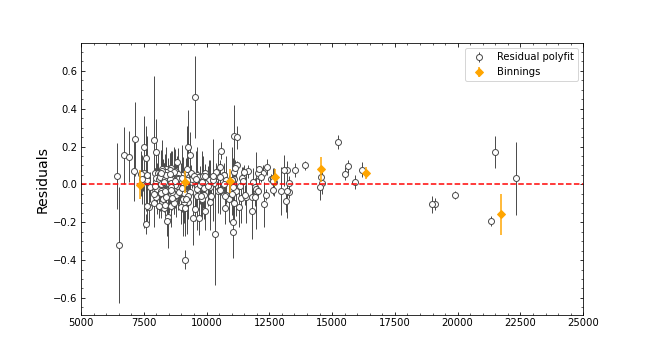

In [40]:
#Graficamos:
fig, ax = plt.subplots(figsize= (9,5))

ax.minorticks_on() #minorticks on
ax.tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)

# Plot the binned medians
ax.errorbar(Regions['T_heavy'], Quadratic_Model[3], yerr= sigma_residual[0], color=colors['Linregress'], fmt = 'o', 
            alpha=1, label = 'Residual polyfit',mfc='white', elinewidth=1, zorder = 0)

ax.errorbar(binninas[0], binninas[1], yerr = binninas[2], color='Orange',fmt = 'D', label='Binnings')

plt.axhline(0, color='r', linestyle='dashed', alpha=1)

ax.set_xlim(5000,25000)
plt.ylabel("Residuals", size = 14)
#plt.title("Binned Median Residuals (0.2 dex bins)")
plt.legend()
plt.grid(False)
plt.show()

<IPython.core.display.Javascript object>


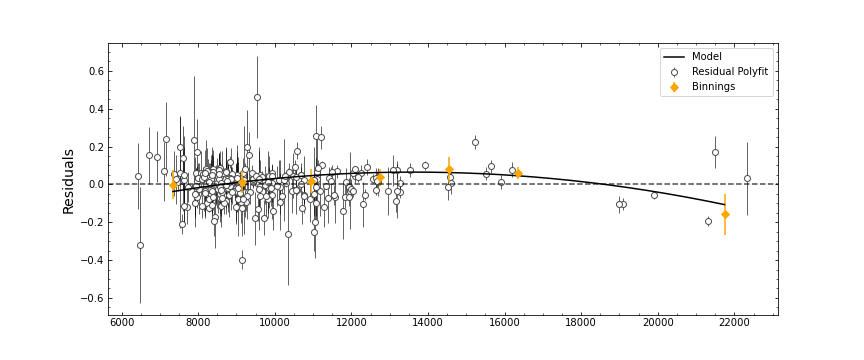

Parámetros ajustados: a = -2.6013484828818197e-09, b = 7.084670037203037e-05, c = -0.4175769732992754


In [45]:
def quadratic_model_binning(O, M, std):
    
    #Definimos mascaras:
    mask = ~np.isnan(M) & ~np.isnan(std)
    O_mask = O[mask]
    M_mask = M[mask]
    std_mask = std[mask]
    
    #Definimos modelo:
    
    def quadratic_func(x, a, b, c):
        return a * x**2 + b * x + c

    # Ajuste de la función cuadrática
    #popt, pcov = curve_fit(quadratic_func, O_mask, M_mask, sigma = std_mask, absolute_sigma=True)
    poly = np.polyfit(O_mask, M_mask,2, w = 1/std_mask)

    # Parámetros ajustados
    #a, b, c = popt
    a,b,c = poly
    
    fig, ax = plt.subplots(figsize= (12,5))
    
    ax.minorticks_on() #minorticks on
    ax.tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)

    
    #Residuos:
    
    ax.errorbar(Regions['T_heavy'], Quadratic_Model[3], yerr= sigma_residual[0], color=colors['Linregress'], fmt = 'o',
            alpha=1, label = 'Residual Polyfit',mfc='white',ecolor = 'k', elinewidth=0.6, zorder = 0)
    
    #Binnings:
    ax.errorbar(binninas[0], binninas[1], yerr = binninas[2], color='Orange',fmt = 'D', label='Binnings', alpha = 1)
    
    #Modelo:
    x_fit = np.linspace(min(binninas[0]), max(binninas[0]), 500)
    
    plt.plot(x_fit, np.dot(np.vander(x_fit, 3), [poly[0],poly[1],poly[2]]), color ='k', label = 'Model' )
    
    plt.axhline(0, color='k', linestyle='dashed', alpha=0.7)
    plt.ylabel('Residuals', size = 14)
    plt.legend(loc = 'best')
    plt.grid(False)
    plt.show()
    plt.savefig('Binnings_polyfit_t2eq0.pdf', format = 'pdf', dpi = 300, bbox_inches='tight')
    return print(f"Parámetros ajustados: a = {a}, b = {b}, c = {c}")

model_binning = quadratic_model_binning(binninas[0], binninas[1], binninas[2])
model_binning

## Quadratic Model results:

$$ 12 + \log(O/H)  = -(2.199 \pm 2.601) \dfrac{T_e^2}{10^9 k^2} - (1.493 \pm 0.708) \dfrac{T_e}{10^4k} + (9.577 \pm 0.417) $$ 